
# Satellite Change Detection Using Sentinel-2

This notebook performs multitemporal land-use change detection using Sentinel-2 image pairs.
It includes:
- RGB visualization
- NDVI calculation and differencing
- Binary change mask
- Patch extraction
- Random Forest classification


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Update with your actual image paths
before_path = "/workspaces/Satellite-Change-Detection/Images/sentinel2_2020.tif"
after_path = "/workspaces/Satellite-Change-Detection/Images/sentinel2_2024.tif"

with rasterio.open(before_path) as src:
    before = src.read()
    print("Shape:", before.shape)
    print("Dtype:", before.dtype)

with rasterio.open(after_path) as src:
    after = src.read()
    print("Shape:", after.shape)
    print("Dtype:", after.dtype)



Shape: (4, 2260, 2007)
Dtype: uint16
Shape: (4, 2260, 2007)
Dtype: uint16


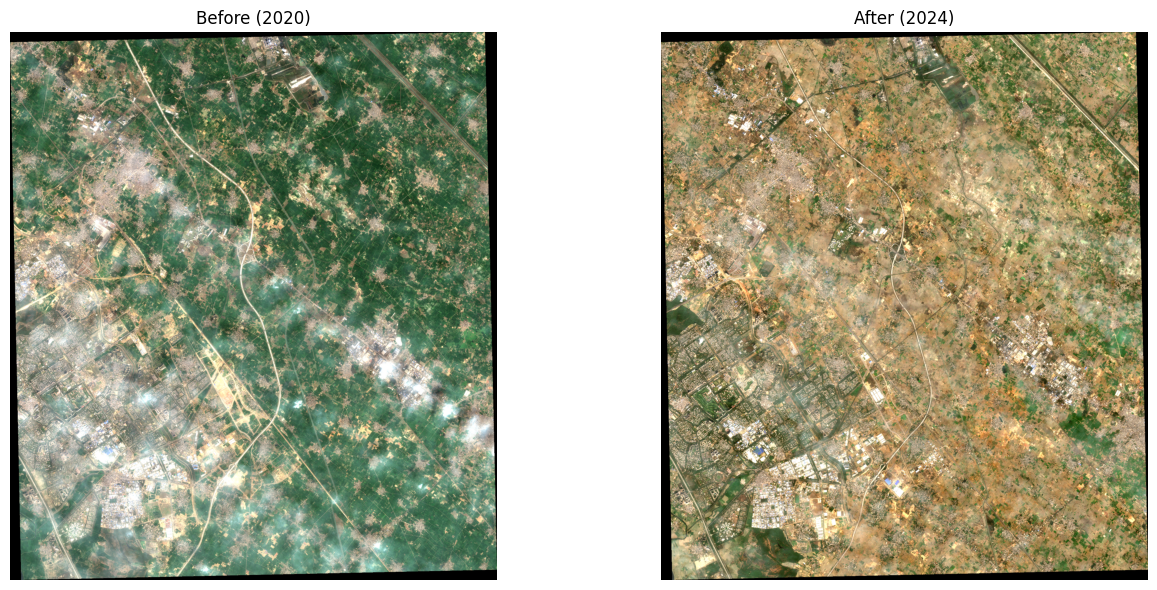

In [2]:

def get_rgb(image):
    rgb = np.stack([image[0], image[1], image[2]], axis=-1)
    rgb = (rgb - np.percentile(rgb, 2)) / (np.percentile(rgb, 98) - np.percentile(rgb, 2))
    return np.clip(rgb, 0, 1)

rgb_before = get_rgb(before)
rgb_after = get_rgb(after)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].imshow(rgb_before)
axs[0].set_title("Before (2020)")
axs[0].axis("off")

axs[1].imshow(rgb_after)
axs[1].set_title("After (2024)")
axs[1].axis("off")
plt.tight_layout()
plt.show()


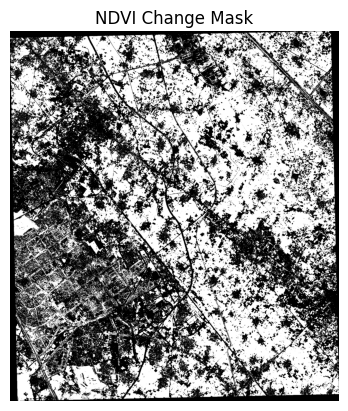

In [3]:

def ndvi(img):
    nir = img[3].astype(float)
    red = img[0].astype(float)
    return (nir - red) / (nir + red + 1e-6)

ndvi_before = ndvi(before)
ndvi_after = ndvi(after)
ndvi_diff = np.abs(ndvi_after - ndvi_before)
change_mask = (ndvi_diff > 0.2).astype(np.uint8)

plt.imshow(change_mask, cmap="gray")
plt.title("NDVI Change Mask")
plt.axis("off")
plt.show()


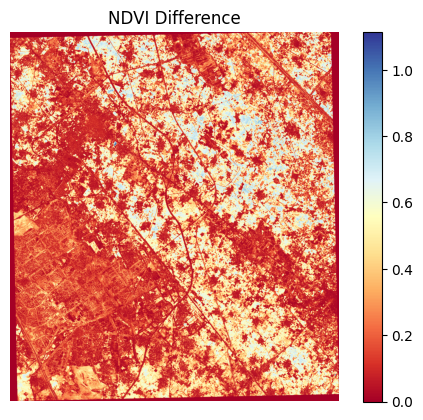

In [4]:
plt.imshow(ndvi_diff, cmap='RdYlBu')
plt.title("NDVI Difference")
plt.colorbar()
plt.axis("off")
plt.show()

In [7]:
import random

def extract_random_patches(img1, img2, mask, size=8, max_samples=10000):
    X, y = [], []
    h, w = mask.shape
    half = size // 2

    # Create all valid center pixel indices
    candidates = [(i, j) for i in range(half, h - half) for j in range(half, w - half)]

    # Sample only max_samples randomly
    sample_indices = random.sample(candidates, min(max_samples, len(candidates)))

    for i, j in sample_indices:
        label = mask[i, j]
        patch1 = img1[:, i - half:i + half, j - half:j + half].flatten()
        patch2 = img2[:, i - half:i + half, j - half:j + half].flatten()
        X.append(np.concatenate([patch1, patch2]))
        y.append(label)

    return np.array(X), np.array(y)

In [8]:
X, y = extract_random_patches(before, after, change_mask, size=8, max_samples=10000)

In [9]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.92      0.89       950
           1       0.92      0.86      0.89      1050

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [10]:
def extract_cnn_patches(img1, img2, mask, size=8, max_samples=10000):
    X, y = [], []
    h, w = mask.shape
    half = size // 2
    candidates = [(i, j) for i in range(half, h - half) for j in range(half, w - half)]
    sample_indices = random.sample(candidates, min(max_samples, len(candidates)))

    for i, j in sample_indices:
        patch1 = img1[:, i - half:i + half, j - half:j + half]  # shape (4, H, W)
        patch2 = img2[:, i - half:i + half, j - half:j + half]
        combined = np.concatenate([patch1, patch2], axis=0)  # shape (8, H, W)
        X.append(combined.transpose(1, 2, 0))  # → (H, W, 8)
        y.append(mask[i, j])

    return np.array(X), np.array(y)


In [11]:
X_cnn, y_cnn = extract_cnn_patches(before, after, change_mask, size=8, max_samples=10000)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_cnn, test_size=0.2, stratify=y_cnn)

# Normalize input
X_train = X_train / 10000.0
X_test = X_test / 10000.0

# Define CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(8, 8, 8)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)


2025-06-13 19:57:35.133415: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 19:57:35.153507: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 19:57:35.409658: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 19:57:35.565999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749844655.851292   17741 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749844655.94

Epoch 1/10


/workspaces/Satellite-Change-Detection/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-13 19:57:40.005958: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7440 - loss: 0.5540 - val_accuracy: 0.8438 - val_loss: 0.3524
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8448 - loss: 0.3444 - val_accuracy: 0.8775 - val_loss: 0.2810
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8795 - loss: 0.2886 - val_accuracy: 0.8925 - val_loss: 0.2609
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8795 - loss: 0.2720 - val_accuracy: 0.9038 - val_loss: 0.2439
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8957 - loss: 0.2497 - val_accuracy: 0.8975 - val_loss: 0.2483
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8963 - loss: 0.2439 - val_accuracy: 0.9137 - val_loss: 0.2247
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9123 - loss: 0.2178 - val_accuracy: 0.9100 - val_loss: 0.2052
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9118 - loss: 0.2077 - val_accuracy: 0.9150 - val_

In [13]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test) > 0.5
print(classification_report(y_test, y_pred.astype(int)))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       968
           1       0.94      0.88      0.91      1032

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [14]:
def predict_full_image(img1, img2, model, patch_size=8, stride=4):
    h, w = img1.shape[1:]  # (bands, height, width)
    half = patch_size // 2
    prob_map = np.zeros((h, w))
    count_map = np.zeros((h, w))

    for i in range(half, h - half, stride):
        for j in range(half, w - half, stride):
            patch1 = img1[:, i - half:i + half, j - half:j + half]
            patch2 = img2[:, i - half:i + half, j - half:j + half]
            combined = np.concatenate([patch1, patch2], axis=0).transpose(1, 2, 0)  # shape: (H, W, 8)
            input_patch = combined[np.newaxis, :, :, :] / 10000.0  # add batch dim + normalize

            prob = model.predict(input_patch, verbose=0)[0][0]
            prob_map[i, j] = prob
            count_map[i, j] += 1

    # Smooth by averaging overlapping predictions
    prob_map[count_map > 0] /= count_map[count_map > 0]
    return prob_map


In [ ]:
heatmap = predict_full_image(before, after, model, patch_size=8, stride=4)

plt.figure(figsize=(10, 6))
plt.imshow(heatmap, cmap="inferno")
plt.colorbar(label="Predicted Change Probability")
plt.title("CNN-Based Land Change Prediction Heatmap")
plt.axis("off")
plt.show()
